# SCRAPPING DATA KEYWORD VIDEOGAMES


In [ ]:
import requests
from bs4 import BeautifulSoup
import csv

# Membuka file CSV untuk menulis data
with open('springer_videogames.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Title', 'Link', 'Publication Date', 'Authors', 'Abstract'])
    
    for page in range(1, 6):  # Mengambil halaman 1 hingga 5
        print(f"Scraping halaman {page}...")
        
        # URL pencarian di SpringerLink dengan pagination
        url = f"https://link.springer.com/search?new-search=true&query=videogames&content-type=Article&sortBy=relevance&page={page}"
        
        # Headers untuk menyamarkan request agar terlihat seperti dari browser
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        }

        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Mencari elemen <li> yang memiliki class "app-card-open"
            articles = soup.find_all('li', {'class': 'app-card-open'})
            
            for article in articles:
                # Mengambil judul artikel
                title_tag = article.find('a', {'class': 'app-card-open__link'})
                title = title_tag.text.strip() if title_tag else 'N/A'
                
                # Mengambil link artikel
                article_link = f"https://link.springer.com{title_tag['href']}" if title_tag else 'N/A'
                
                # Mengambil tanggal publikasi
                date_tag = article.find('span', {'class': 'c-meta__item', 'data-test': 'published'})
                publish_date = date_tag.text.strip() if date_tag else 'N/A'
                
                # Mengambil nama penulis dan abstrak dari halaman artikel
                authors = []
                abstract = 'N/A'
                
                if article_link != 'N/A':
                    article_response = requests.get(article_link, headers=headers)
                    if article_response.status_code == 200:
                        article_soup = BeautifulSoup(article_response.text, 'html.parser')
                        
                        # Mengambil nama penulis
                        author_tags = article_soup.find_all('a', {'data-test': 'author-name'})
                        authors = [author.text.strip() for author in author_tags]
                        
                        # Mengambil abstrak
                        abstract_tag = article_soup.find('section', {'data-title': 'Abstract'})
                        if abstract_tag:
                            abstract_content = abstract_tag.find('p')
                            abstract = abstract_content.text.strip() if abstract_content else 'N/A'

                writer.writerow([title, article_link, publish_date, ', '.join(authors), abstract])
        else:
            print(f"Gagal mengakses halaman {page}, status code: {response.status_code}")

print("Data berhasil disimpan ke 'springer_videogames.csv'.")


# PREPROCESSING

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

df = pd.read_csv('springer_videogames.csv')

# Daftar normalisasi singkatan
abbreviation_mapping = {
    "sps": "social problem solving",
    "scm": "supply chain management",
    "dsc": "digital supply chain",
    "covid": "coronavirus disease",
    "pisa": "programme for international student assessment",
    "asd": "autism spectrum disorder",
    "pass": "planning attention simultaneous successive",
    "tv": "television",
    "pls": "partial least squares",
    "baq": "body appreciation questionnaire",
    "uk": "united kingdom",
    "us": "united states",
    "bmi": "body mass index",
    "npc": "non-playable character",
    "vr": "virtual reality",
    "icd": "international classification of diseases",
    "igdt": "internet gaming disorder test",
    "sd": "standard deviation",
    "mako": "makoplasty",
    "sf": "science fiction",
    "ci": "confidence interval",
    "prisma": "preferred reporting items for systematic reviews and meta-analyses",
    "robust": "reliable and objectively measured",
    "cpv": "child physical violence",
    "cinahl": "cumulative index to nursing and allied health literature",
    "pc": "personal computer",
    "igd": "internet gaming disorder",
    "piu": "problematic internet use",
    "gd": "generalized disorder",
    "er": "emergency room",
    "sr": "systematic review",
    "ed": "eating disorder",
    "medline": "medical literature analysis and retrieval system online",
    "ucc": "universal credit center",
    "vasc": "vascular",
    "insee": "national institute of statistics and economic studies",
    "nuts": "nomenclature of territorial units for statistics",
    "lra": "latent response analysis",
    "hexaco": "hexaco personality inventory",
    "ai": "artificial intelligence",
    "ml": "machine learning",
    "aim": "artificial intelligence in medicine",
    "ri": "response inhibition",
    "clpm": "cross-lagged panel model",
    "or": "odds ratio",
    "ses": "socioeconomic status",
    "sias": "social interaction anxiety scale",
    "brs": "brief resilience scale",
    "scms": "supply chain management systems",
    "fps": "first-person shooter",
    "fc": "factorial complexity",
    "bci": "brain-computer interface",
    "pl": "psycholinguistics",
    "hmd": "head-mounted display",
    "ptsd": "post-traumatic stress disorder",
    "ppd": "postpartum depression",
    "gad": "generalized anxiety disorder",
    "epds": "edinburgh postnatal depression scale",
    "dsm": "diagnostic and statistical manual of mental disorders",
    "ivr": "immersive virtual reality",
    "boxvr": "a specific vr fitness game",
    "hrv": "heart rate variability",
    "hr": "heart rate",
    "sdnn": "standard deviation of normal-to-normal intervals",
    "acm": "association for computing machinery",
    "gps": "global positioning system",
    "crf": "cardiorespiratory fitness",
    "iq": "intelligence quotient"
}

# Fungsi untuk mengganti singkatan dengan kata lengkap di kolom 'Abstract'
def normalize_abbreviations(text):
    for abbr, full_form in abbreviation_mapping.items():
        text = re.sub(r'\b' + re.escape(abbr) + r'\b', full_form, text)
    return text

# 1. Menangani nilai kosong di kolom 'Abstract'
df['Abstract'] = df['Abstract'].fillna('')

# 2. Normalisasi teks di kolom 'Abstract' (ubah menjadi huruf kecil)
df['Preprocess Abstract'] = df['Abstract'].str.lower()

# 3. Mengganti singkatan dengan bentuk lengkapnya
df['Preprocess Abstract'] = df['Preprocess Abstract'].apply(normalize_abbreviations)

# 4. Membersihkan teks di kolom 'Preprocess Abstract' (menghapus karakter khusus tetapi mempertahankan kata dan spasi)
df['Preprocess Abstract'] = df['Preprocess Abstract'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# 5. Menghapus stopword dari kolom 'Preprocess Abstract'
stopwords = set(ENGLISH_STOP_WORDS)
df['Preprocess Abstract'] = df['Preprocess Abstract'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stopwords])
)


output_path = 'springer_videogames_dengan_preprocessing.csv'
df.to_csv(output_path, index=False)


# ANALISIS dan INSIGHT

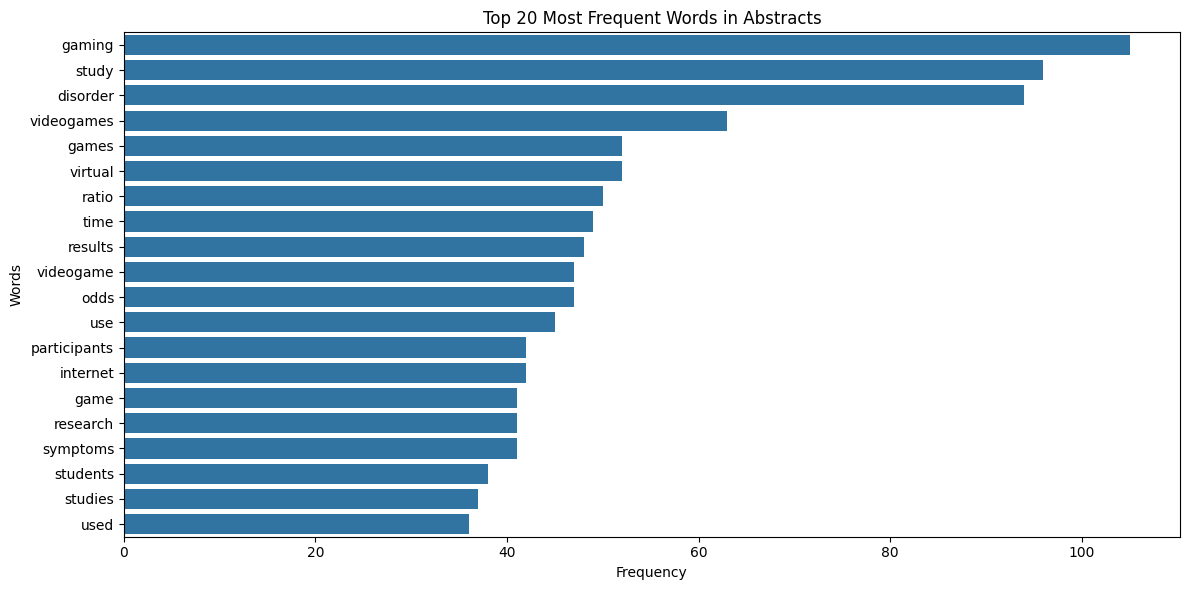

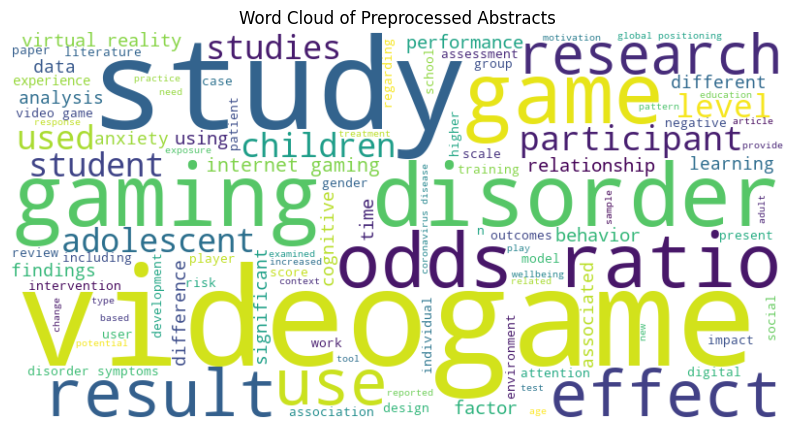

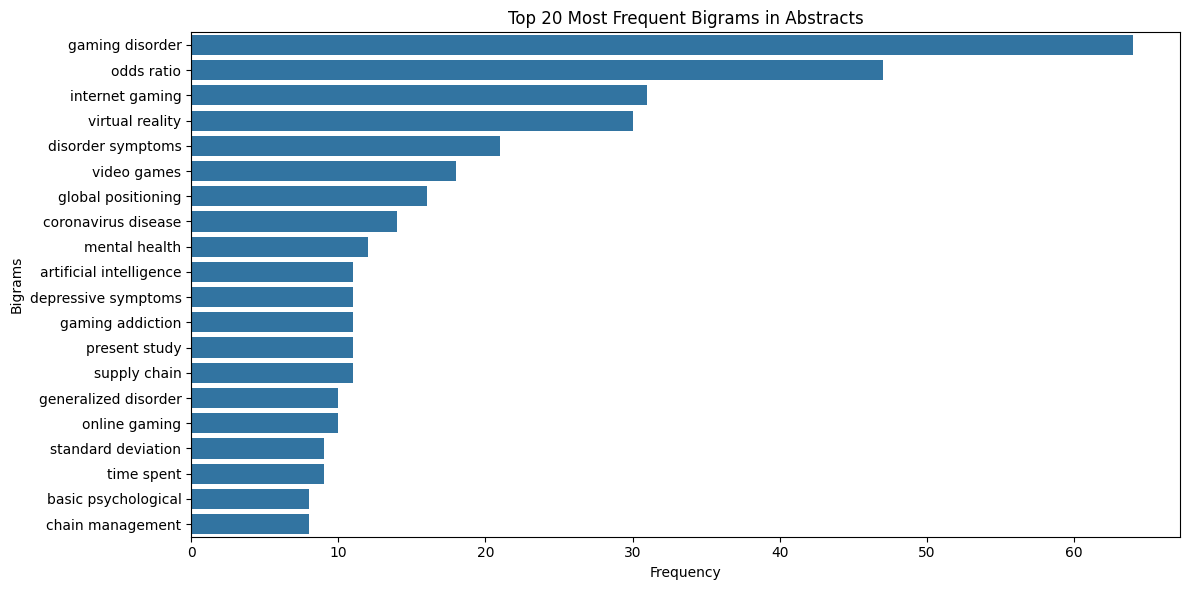

Rata-rata panjang kalimat di abstract setelah preprocessing adalah 92.37 kata.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns

df = pd.read_csv('springer_videogames_dengan_preprocessing.csv')

df['Preprocess Abstract'] = df['Preprocess Abstract'].fillna('')

df['Preprocess Abstract'] = df['Preprocess Abstract'].astype(str)

all_words = ' '.join(df['Preprocess Abstract'])

word_counts = Counter(all_words.split())

# Menampilkan 20 kata teratas berdasarkan frekuensi
top_words = word_counts.most_common(20)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Visualisasi Top 20 Kata
plt.figure(figsize=(12, 6))
sns.barplot(data=top_words_df, x='Frequency', y='Word')
plt.title('Top 20 Most Frequent Words in Abstracts')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# Word Cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Abstracts')
plt.show()

# 5. Analisis N-gram (Bigram)
from sklearn.feature_extraction.text import CountVectorizer

# Menghitung bigram
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigrams = vectorizer.fit_transform(df['Preprocess Abstract'])

# Menampilkan top 20 bigram
bigram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bigrams.sum(axis=0).tolist()[0])))
top_bigrams = bigram_counts.most_common(20)
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])

# Visualisasi Top 20 Bigram
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bigrams_df, x='Frequency', y='Bigram')
plt.title('Top 20 Most Frequent Bigrams in Abstracts')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.tight_layout()
plt.show()

# 6. Insight Tambahan: Analisis Panjang Kalimat Rata-rata
df['Word Count'] = df['Preprocess Abstract'].apply(lambda x: len(x.split()))
avg_word_count = df['Word Count'].mean()
print(f'Rata-rata panjang kalimat di abstract setelah preprocessing adalah {avg_word_count:.2f} kata.')


# FEATURE ENGINEERING TF-IDF


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('springer_videogames_dengan_preprocessing.csv')

texts = df['Preprocess Abstract'].fillna('')

tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Mengambil 1000 fitur teratas berdasarkan frekuensi kata

# Transformasikan teks menjadi matriks TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Konversi hasil TF-IDF ke dalam DataFrame dengan fitur (kata) sebagai kolom
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

output_path = 'springer_videogames_tfidf_features.csv'
tfidf_df.to_csv(output_path, index=False)

print(f"Hasil TF-IDF telah disimpan di {output_path}")
